# Predicting Winners

We will try to predict the winners in the following categories:
1. Best Picture
2. Best Actress
3. Best Actor
4. Best Supporting Actress
5. Best Supporting Actor
6. Best Director
7. Best Screenplay

We will use the following models for prediction because they gave the best Results while predicting the nominations.
1. Logistic Regression
2. Random Forest Algorithm
3. Neural Network

In [22]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

# scikit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score

import tensorflow as tf


In [56]:
DF_main = pd.read_csv('my_data/df_main_FINAL.csv', index_col=[0])
all_genres = pickle.load(open("my_data/all_genres_FINAL","rb"))
oscar_categories = pickle.load(open("my_data/major_oscar_categories","rb"))
oscar_genres_columns = ['sci-fi', 'family', 'adventure', 'crime', 
                'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 
                'horror', 'drama', 'mystery', 'war', 'thriller']



ID_columns = ['imdbID', 'title', 'year']
basic_columns = ['cast_size', 'genre_span']

    
print("Oscar genres:\n",oscar_genres_columns)
print("Oscar categories:\n", oscar_categories)



scores = ['n_votes','imdb_rating', 'metscore', 'rotten_tomatoes']
awards_pre = ['precount_wins', 'precount_noms', 'other_wins', 'other_noms']
awards_post = ['win', 'nom']

predictor_columns = basic_columns + oscar_genres_columns + scores + awards_pre

print("Predictor columns:\n",predictor_columns)
target_columns = ['win', 'nom']
filters = ((DF_main.drama==1)|((DF_main.comedy==1)|(DF_main.romance==1)|(DF_main.biography==1)))&(DF_main.action==0)
DF_main = DF_main[filters]
# DF_main.drop('action', axis=1, inplace=True)

Oscar genres:
 ['sci-fi', 'family', 'adventure', 'crime', 'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 'horror', 'drama', 'mystery', 'war', 'thriller']
Oscar categories:
 ['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay']
Predictor columns:
 ['cast_size', 'genre_span', 'sci-fi', 'family', 'adventure', 'crime', 'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 'horror', 'drama', 'mystery', 'war', 'thriller', 'n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes', 'precount_wins', 'precount_noms', 'other_wins', 'other_noms']


In [57]:
def convert_to_pctile(X, columns):
    
    for col in columns:
        x = np.array(X[col])
        X[col] = [(len(np.where(x<=y)[0])/len(x)) for y in x]
    return X

def normalize_by_max(X, columns):
    for col in columns:
        x = np.array(X[col])
        mx = np.max(x)
        X[col] = x/mx
    return X

def top_N_each_year(df,N,feature):
    df_ = pd.DataFrame()
    for year in list(set(df.year)):
        # print(year)
        df_ = df_.append(df[df.year == year].sort_values(by = feature, ascending=False).head(N))
    return df_

def normalize_by_year(df, columns, _how = 'max'):
    
    if type(columns)!= list:
        print("columns must be list")
        return dict()
    years = list(set(df.year))

    print(years)
    
    if _how == 'pctile':
        df = convert_to_pctile(df, columns)
        return df

    for column in columns:
        cols = ['year'] + [column]
        for year in years:
            if year%10 == 0:
                clear_output() 
            print(year, column)
            temp_df = df[(df.year == year)]
            temp_df = temp_df[column]
            ids = temp_df.index
            
            if _how == 'max':
                df.loc[ids,column] = df.loc[ids,column]/temp_df.max()
            if _how == 'minmax':
                min_max_scaler = preprocessing.MinMaxScaler()
                vals = df.loc[ids,column].values
                # vals.shape = (len(vals),1)
                print(vals.shape)
                vals = vals[:,np.newaxis]
                print(vals.shape)
                scaled_array = min_max_scaler.fit_transform(vals)
                df.loc[ids,column] = scaled_array
            
                
    return df

In [58]:
print(DF_main.columns)
normalize_columns = ['n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes',
                     'cast_size', 'genre_span', 'cast_size', 'running_time']
# DF = normalize_by_year(DF_main, normalize_columns, 'max')
DF_main = normalize_by_year(DF_main, normalize_columns, 'max')

2010 running_time
2011 running_time
2012 running_time
2013 running_time
2014 running_time
2015 running_time
2016 running_time
2017 running_time
2018 running_time
2019 running_time


In [47]:
# Machine Learning

def all_predict(X, y, X_2019, num_models, NUM_MODELS, figsize = (10,10), suptitle = category):
    
    
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(suptitle, fontsize=16)
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    ##############################################
    ## Logreg
    model = LogisticRegression(random_state=0)
    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty=penalty)
    model = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
    model.fit(X, y)
    y_pred = model.predict(X_2019)
    y_prob = model.predict_proba(X_2019)[:,1]
    DFX_2019.loc[:,'predicted_probability_log'] = y_prob
    x = DFX_2019.sort_values(by='predicted_probability_log', ascending=False).head(10)
    # clear_output()

    ### Performance evaluation and plot
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    target_names = ['class 0', 'class 1']
    clear_output() 
    x = x.iloc[::-1,:]
    print(model.best_params_)
    print(model.score(X, y))
    ax = plt.subplot(2, 2, 1)
    ax.barh(x['title'], x['predicted_probability_log'])
    plt.xlabel('probability')
    ax.set_title("Logistic Regression")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    
    ################################################################
    # Random Forest Classifier
    model = RandomForestClassifier() # n_estimators=100)
    param_grid = {'n_estimators': np.arange(50,100,5)} 
    model = GridSearchCV(model, param_grid, cv=5) 
    
    model.fit(X, y)
    y_pred = model.predict(X_2019)
    y_prob = model.predict_proba(X_2019)[:,1]
    DFX_2019.loc[:,'predicted_probability_rfc'] = y_prob
    x = DFX_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)

    ### Performance evaluation and plot
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    target_names = ['class 0', 'class 1']
    clear_output() 
    x = x.iloc[::-1,:]
    print(model.best_params_)
    print(model.score(X, y))
    ax = plt.subplot(2, 2, 2)
    ax.barh(x['title'], x['predicted_probability_rfc'])
    plt.xlabel('probability')
    ax.set_title("Random Forest")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    
    
    ################################################################


    # Neural Network
    model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10,10), max_iter=1000, random_state=41)
    model.fit(X, y)
    y_pred = model.predict(X_2019)
    y_prob = model.predict_proba(X_2019)[:,1]
    DFX_2019.loc[:,'predicted_probability_mlp'] = y_prob
    x = DFX_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)

    ### Performance evaluation and plot
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    target_names = ['class 0', 'class 1']
    clear_output() 
    x = x.iloc[::-1,:]
    print(model.score(X, y))
    ax = plt.subplot(2, 2, 3)
    plt.barh(x['title'], x['predicted_probability_mlp'])
    plt.xlabel('probability')
    ax.set_title("Neural Network")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
   

    
    # Deep Network
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu, input_dim=X.shape[1]))
    model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
    # model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))
    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    model.fit(X, y, epochs = 10)
    y_pred = model.predict([X_2019])

    y_prob = y_pred
    DFX_2019.loc[:,'predicted_probability_deep'] = y_prob[:,1]
    x = DFX_2019.sort_values(by='predicted_probability_deep', ascending=False).head(10)
    x = x.iloc[::-1,:]

    ## Plot
    ax = plt.subplot(2, 2, 4)
    ax.barh(x['title'], x['predicted_probability_deep'])
    plt.xlabel('probability')
    ax.set_title("Deep Network")



# Define Category

## Best Picture

0.8082191780821918


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     class 0       0.81      1.00      0.89        71
     class 1       0.00      0.00      0.00        17

    accuracy                           0.81        88
   macro avg       0.40      0.50      0.45        88
weighted avg       0.65      0.81      0.72        88

Confusion Matrix:
 [[71  0]
 [17  0]]
Train on 292 samples
Epoch 1/10
292/292 [==============================] - 0s 1ms/sample - loss: 0.7244 - accuracy: 0.7774
Epoch 2/10
292/292 [==============================] - 0s 38us/sample - loss: 0.6232 - accuracy: 0.7671
Epoch 3/10
292/292 [==============================] - 0s 71us/sample - loss: 0.5358 - accuracy: 0.8116
Epoch 4/10
292/292 [==============================] - 0s 69us/sample - loss: 0.5050 - accuracy: 0.8253
Epoch 5/10
292/292 [==============================] - 0s 64us/sample - loss: 0.4791 - accuracy: 0.8014
Epoch 6/10
292/292 [==============================] - 0s 67us/sample - loss: 0.4837 - accuracy: 0.81

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


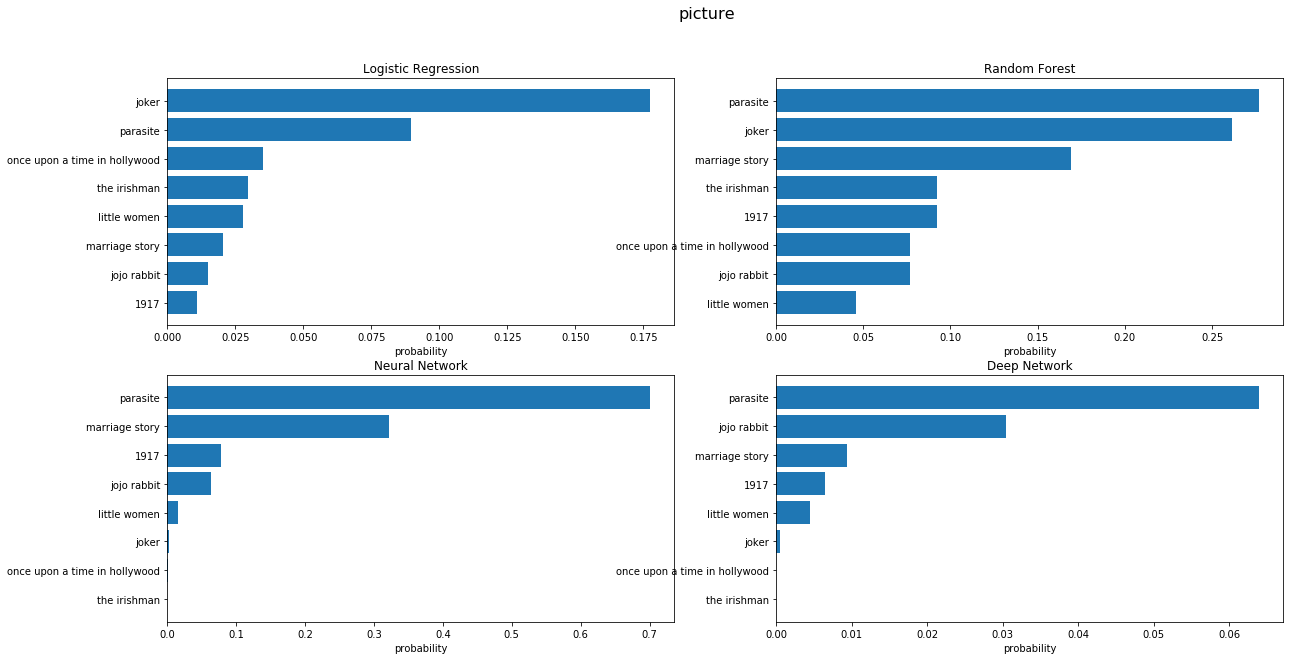

In [69]:
# Only consider nominees for that category
category = 'picture'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Director

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.8353909465020576
              precision    recall  f1-score   support

     class 0       0.84      0.91      0.87        56
     class 1       0.58      0.41      0.48        17

    accuracy                           0.79        73
   macro avg       0.71      0.66      0.68        73
weighted avg       0.78      0.79      0.78        73

Confusion Matrix:
 [[51  5]
 [10  7]]
Train on 243 samples
Epoch 1/10
243/243 [==============================] - 0s 1ms/sample - loss: 4.9490 - accuracy: 0.2675
Epoch 2/10
243/243 [==============================] - 0s 45us/sample - loss: 1.4804 - accuracy: 0.7613
Epoch 3/10
243/243 [==============================] - 0s 46us/sample - loss: 1.3906 - accuracy: 0.7695
Epoch 4/10
243/243 [==============================] - 0s 72us/sample - loss: 0.7247 - accuracy: 0.7572
Epoch 5/10
243/243 [==============================] - 0s 62us/sample - loss: 0.6452 - accuracy: 0.7572
Epoch 6/10
243/243 [==============================] - 0s 69us/sample - loss: 0.56

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


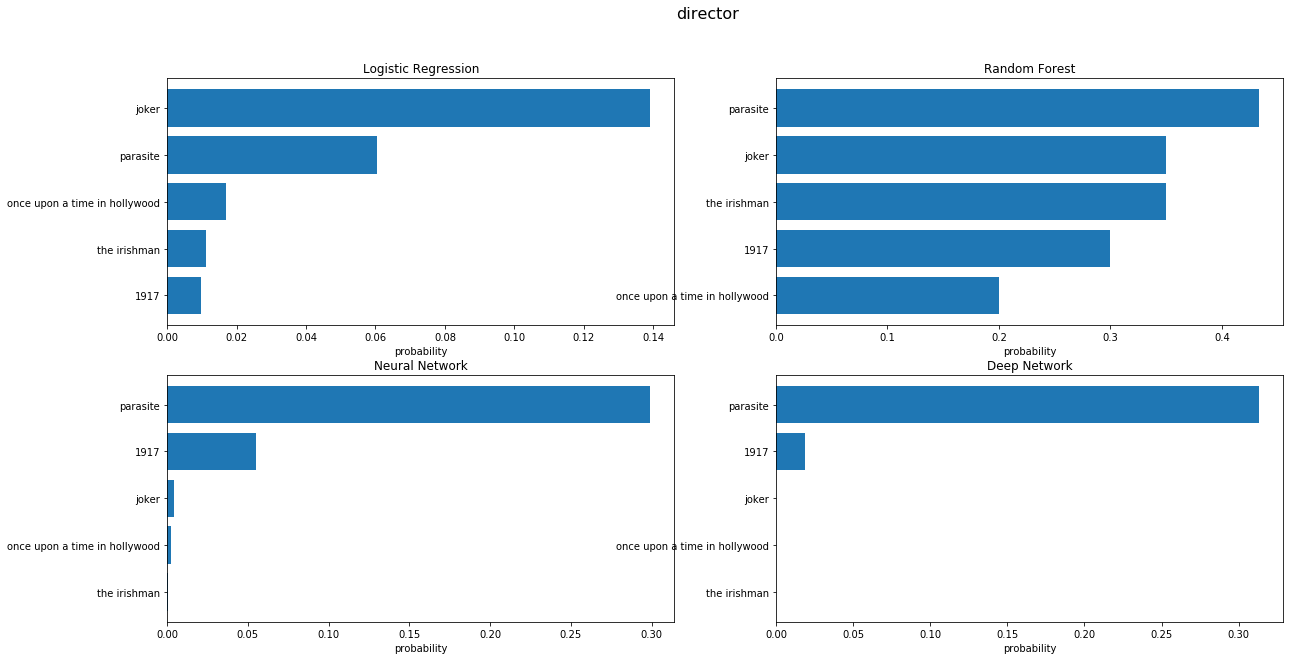

In [71]:
# Only consider nominees for that category
category = 'director'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Actor

0.796875
              precision    recall  f1-score   support

     class 0       0.80      0.98      0.88        61
     class 1       0.50      0.06      0.11        16

    accuracy                           0.79        77
   macro avg       0.65      0.52      0.50        77
weighted avg       0.74      0.79      0.72        77

Confusion Matrix:
 [[60  1]
 [15  1]]
Train on 256 samples
Epoch 1/10


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


256/256 [==============================] - 0s 1ms/sample - loss: 1.9997 - accuracy: 0.7852
Epoch 2/10
256/256 [==============================] - 0s 72us/sample - loss: 0.7391 - accuracy: 0.5117
Epoch 3/10
256/256 [==============================] - 0s 72us/sample - loss: 0.6568 - accuracy: 0.6914
Epoch 4/10
256/256 [==============================] - 0s 75us/sample - loss: 0.6562 - accuracy: 0.7461
Epoch 5/10
256/256 [==============================] - 0s 79us/sample - loss: 0.5632 - accuracy: 0.7422
Epoch 6/10
256/256 [==============================] - 0s 63us/sample - loss: 0.5723 - accuracy: 0.7891
Epoch 7/10
256/256 [==============================] - 0s 84us/sample - loss: 0.5308 - accuracy: 0.7852
Epoch 8/10
256/256 [==============================] - 0s 64us/sample - loss: 0.5146 - accuracy: 0.7891
Epoch 9/10
256/256 [==============================] - 0s 77us/sample - loss: 0.5011 - accuracy: 0.7891
Epoch 10/10
256/256 [==============================] - 0s 66us/sample - loss: 0.5139 

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


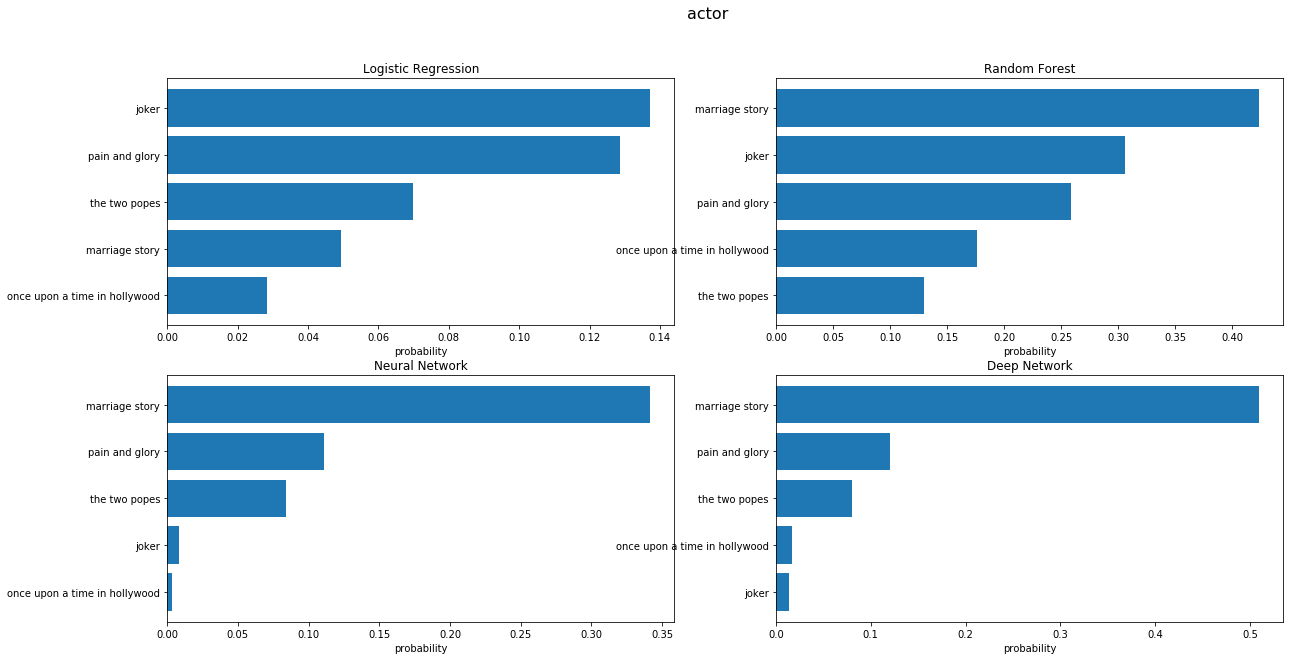

In [72]:
# Only consider nominees for that category
category = 'actor'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Actress

0.8283582089552238
              precision    recall  f1-score   support

     class 0       0.81      0.95      0.88        64
     class 1       0.50      0.18      0.26        17

    accuracy                           0.79        81
   macro avg       0.66      0.56      0.57        81
weighted avg       0.75      0.79      0.75        81

Confusion Matrix:
 [[61  3]
 [14  3]]
Train on 268 samples
Epoch 1/10


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


268/268 [==============================] - 0s 1ms/sample - loss: 0.7625 - accuracy: 0.6493
Epoch 2/10
268/268 [==============================] - 0s 60us/sample - loss: 0.7928 - accuracy: 0.7873
Epoch 3/10
268/268 [==============================] - 0s 80us/sample - loss: 0.5222 - accuracy: 0.7761
Epoch 4/10
268/268 [==============================] - 0s 80us/sample - loss: 0.5043 - accuracy: 0.7836
Epoch 5/10
268/268 [==============================] - 0s 92us/sample - loss: 0.5085 - accuracy: 0.7948
Epoch 6/10
268/268 [==============================] - 0s 92us/sample - loss: 0.4817 - accuracy: 0.7724
Epoch 7/10
268/268 [==============================] - 0s 110us/sample - loss: 0.4929 - accuracy: 0.7575
Epoch 8/10
268/268 [==============================] - 0s 85us/sample - loss: 0.4704 - accuracy: 0.7910
Epoch 9/10
268/268 [==============================] - 0s 94us/sample - loss: 0.4665 - accuracy: 0.7873
Epoch 10/10
268/268 [==============================] - 0s 76us/sample - loss: 0.4652

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


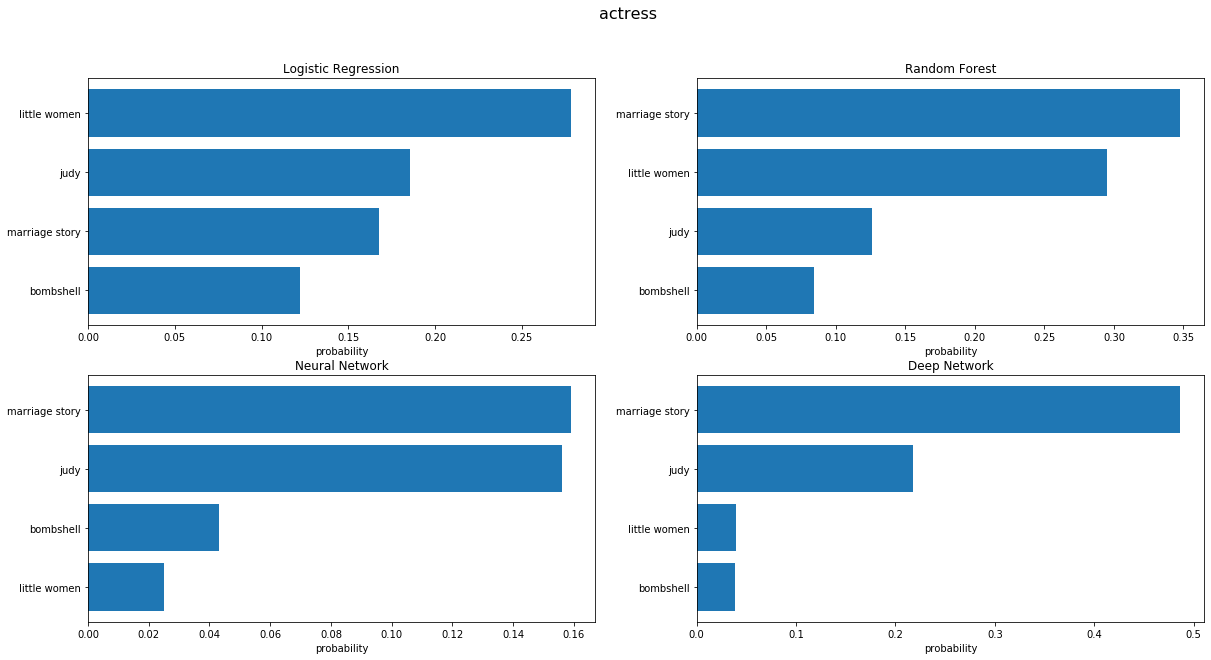

In [73]:
# Only consider nominees for that category
category = 'actress'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Supporting Actress

0.7741935483870968
              precision    recall  f1-score   support

     class 0       0.77      1.00      0.87        58
     class 1       0.00      0.00      0.00        17

    accuracy                           0.77        75
   macro avg       0.39      0.50      0.44        75
weighted avg       0.60      0.77      0.67        75

Confusion Matrix:
 [[58  0]
 [17  0]]
Train on 248 samples
Epoch 1/10


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


248/248 [==============================] - 0s 1ms/sample - loss: 2.0199 - accuracy: 0.5766
Epoch 2/10
248/248 [==============================] - 0s 47us/sample - loss: 1.1066 - accuracy: 0.7621
Epoch 3/10
248/248 [==============================] - 0s 46us/sample - loss: 0.8323 - accuracy: 0.6210
Epoch 4/10
248/248 [==============================] - 0s 51us/sample - loss: 0.6451 - accuracy: 0.7702
Epoch 5/10
248/248 [==============================] - 0s 67us/sample - loss: 0.5592 - accuracy: 0.7742
Epoch 6/10
248/248 [==============================] - 0s 61us/sample - loss: 0.5426 - accuracy: 0.7661
Epoch 7/10
248/248 [==============================] - 0s 78us/sample - loss: 0.5330 - accuracy: 0.7823
Epoch 8/10
248/248 [==============================] - 0s 62us/sample - loss: 0.5513 - accuracy: 0.7661
Epoch 9/10
248/248 [==============================] - 0s 60us/sample - loss: 0.5415 - accuracy: 0.7621
Epoch 10/10
248/248 [==============================] - 0s 68us/sample - loss: 0.5414 

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


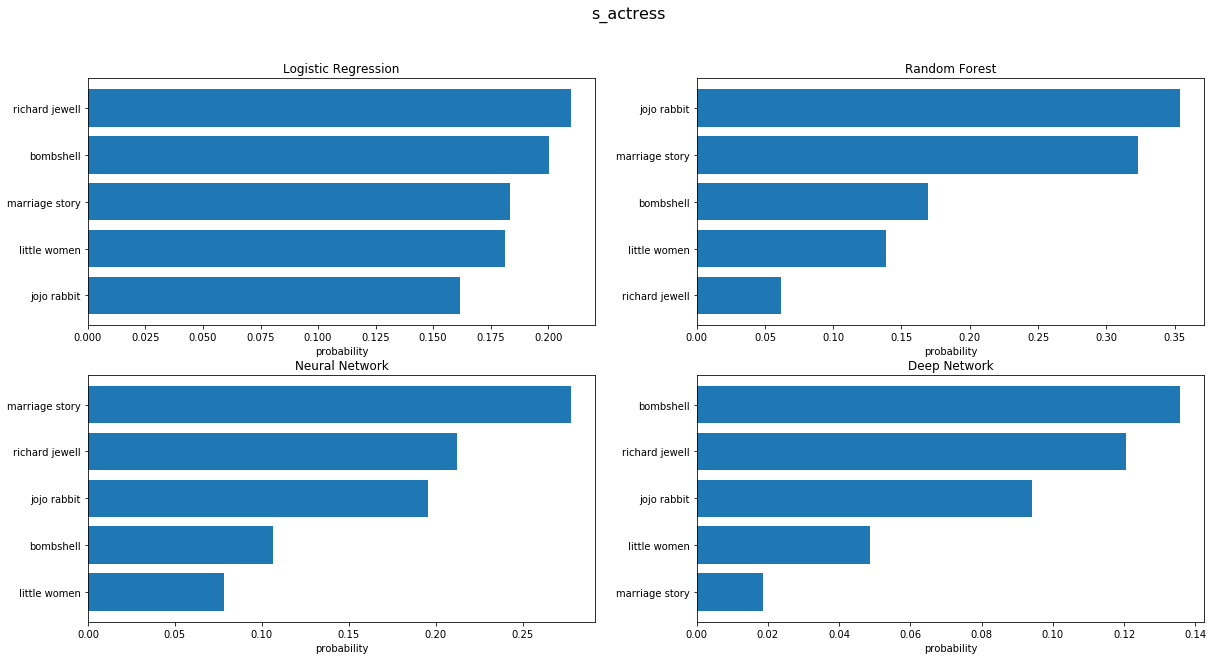

In [74]:
# Only consider nominees for that category
category = 's_actress'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Supporting Actor

0.7818930041152263


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     class 0       0.78      1.00      0.88        57
     class 1       0.00      0.00      0.00        16

    accuracy                           0.78        73
   macro avg       0.39      0.50      0.44        73
weighted avg       0.61      0.78      0.68        73

Confusion Matrix:
 [[57  0]
 [16  0]]
Train on 243 samples
Epoch 1/10
243/243 [==============================] - 0s 1ms/sample - loss: 1.0621 - accuracy: 0.6420
Epoch 2/10
243/243 [==============================] - 0s 46us/sample - loss: 0.7853 - accuracy: 0.7654
Epoch 3/10
243/243 [==============================] - 0s 45us/sample - loss: 0.5986 - accuracy: 0.7325
Epoch 4/10
243/243 [==============================] - 0s 60us/sample - loss: 0.5711 - accuracy: 0.7778
Epoch 5/10
243/243 [==============================] - 0s 75us/sample - loss: 0.5478 - accuracy: 0.7572
Epoch 6/10
243/243 [==============================] - 0s 58us/sample - loss: 0.5216 - accuracy: 0.78

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


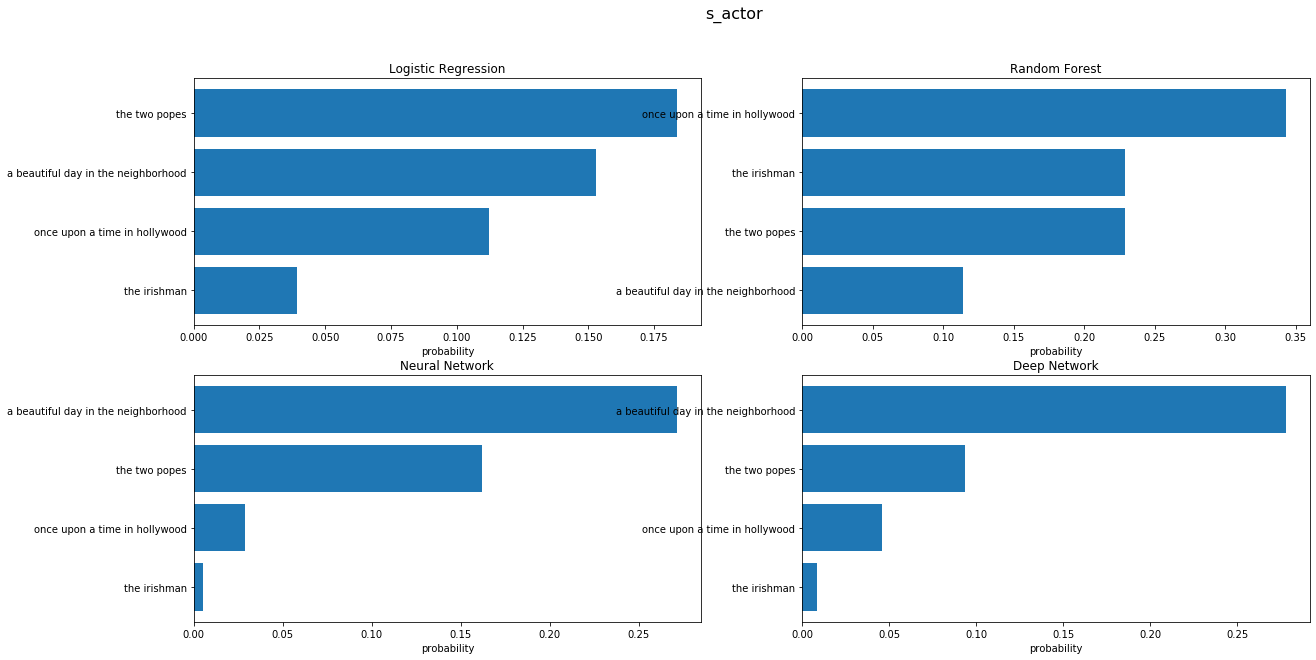

In [75]:
# Only consider nominees for that category
category = 's_actor'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

## Best Screenplay

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.8026905829596412
              precision    recall  f1-score   support

     class 0       0.80      0.93      0.86       105
     class 1       0.42      0.17      0.24        29

    accuracy                           0.77       134
   macro avg       0.61      0.55      0.55       134
weighted avg       0.72      0.77      0.73       134

Confusion Matrix:
 [[98  7]
 [24  5]]
Train on 446 samples
Epoch 1/10
446/446 [==============================] - 0s 637us/sample - loss: 0.7292 - accuracy: 0.6861
Epoch 2/10
446/446 [==============================] - 0s 50us/sample - loss: 0.6663 - accuracy: 0.7466
Epoch 3/10
446/446 [==============================] - 0s 61us/sample - loss: 0.5998 - accuracy: 0.7713
Epoch 4/10
446/446 [==============================] - 0s 54us/sample - loss: 0.5562 - accuracy: 0.7848
Epoch 5/10
446/446 [==============================] - 0s 65us/sample - loss: 0.5161 - accuracy: 0.7848
Epoch 6/10
446/446 [==============================] - 0s 54us/sample - loss: 0.

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


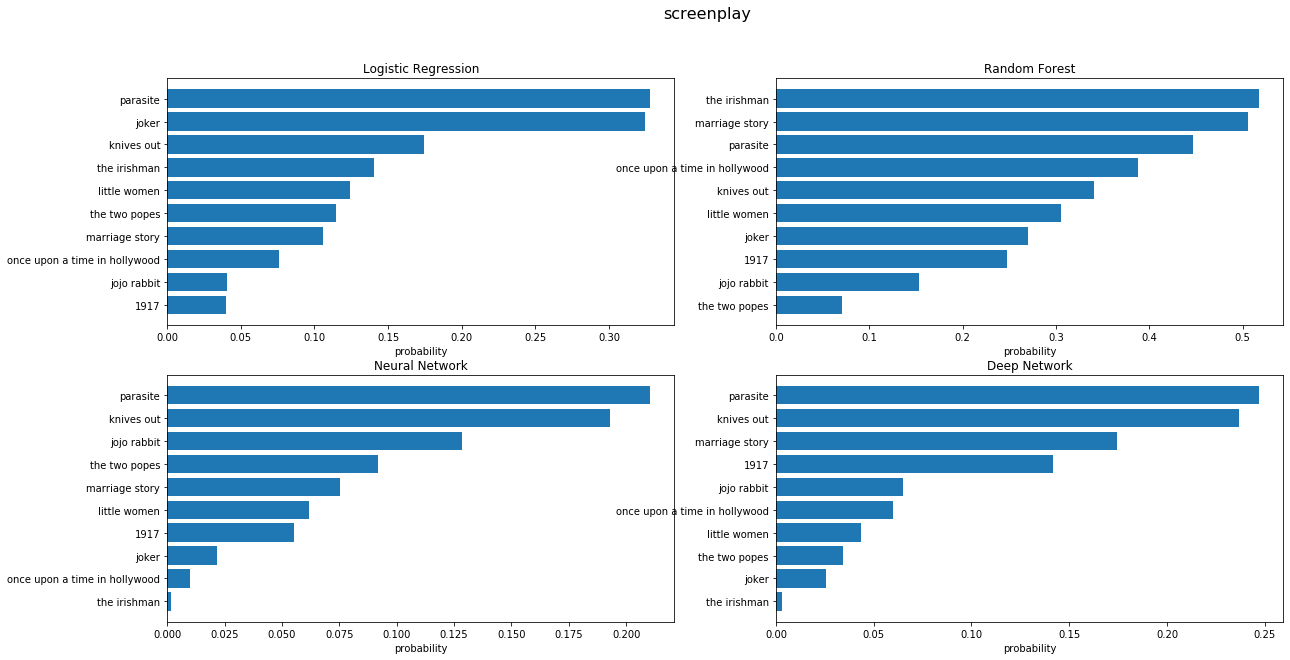

In [77]:
# Only consider nominees for that category
category = 'screenplay'
DF = DF_main[DF_main[category]!='O']
# DF.info()

# Pre 2019 (predictor) movies
# Predictor matrix
DF1 = DF[(DF_main.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':0, 'WN':1}
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )

DF1[category].head(10).tail()

all_predict(X, y, X_2019, 2, 2, figsize=(20,10), suptitle = category)

# Older: Dekete after Results

# Logistic Regression

Because we are interested in obtaining probabilities for each film earning a nomination, and inferring the winner from these probabilities, the only linear model that was considered was Logistic Regression. Because Logistic regression uses the logistic function to model a binary dependent variable, the output of the model can be naturally interpreted as the probability of nomination or not. 

{'C': 1.0, 'penalty': 'l1'}
0.8116438356164384
              precision    recall  f1-score   support

     class 0       0.82      0.93      0.87        71
     class 1       0.38      0.18      0.24        17

    accuracy                           0.78        88
   macro avg       0.60      0.55      0.56        88
weighted avg       0.74      0.78      0.75        88

Confusion Matrix:
 [[66  5]
 [14  3]]


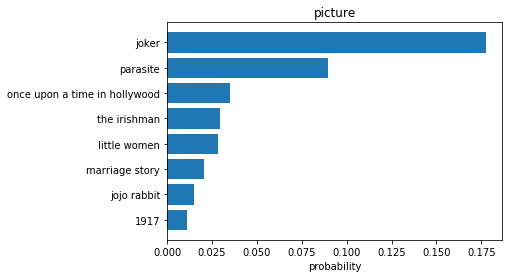

In [13]:
log = LogisticRegression(random_state=0)
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log_cv = GridSearchCV(log, hyperparameters, cv=5, verbose=0)
log_cv.fit(X, y)
y_pred = log_cv.predict(X_2019)
y_prob = log_cv.predict_proba(X_2019)[:,1]
DFX_2019.loc[:,'predicted_probability_log'] = y_prob
x = DFX_2019.sort_values(by='predicted_probability_log', ascending=False).head(10)
clear_output()

### Performance evaluation
log_cv.fit(X_train, y_train)
y_pred = log_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(log_cv.best_params_)
print(log_cv.score(X, y))
plt.barh(x['title'], x['predicted_probability_log'])
plt.xlabel('probability')
plt.title(category)
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Random Forest Classifier

{'n_estimators': 55}
              precision    recall  f1-score   support

     class 0       0.84      0.94      0.89        71
     class 1       0.50      0.24      0.32        17

    accuracy                           0.81        88
   macro avg       0.67      0.59      0.60        88
weighted avg       0.77      0.81      0.78        88

Confusion Matrix:
 [[67  4]
 [13  4]]


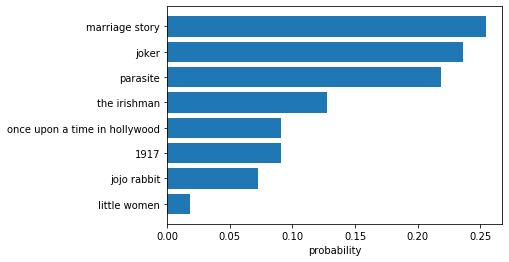

In [21]:
rfc=RandomForestClassifier() # n_estimators=100)
param_grid = {'n_estimators': np.arange(50,100,5)} 
rfc_cv = GridSearchCV(rfc, param_grid, cv=5) 

rfc_cv.fit(X,y)
y_pred = rfc_cv.predict(X_2019)
y_prob = rfc_cv.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_rfc'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)

### Performance evaluation
rfc_cv.fit(X_train, y_train)
y_pred = rfc_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(rfc_cv.best_params_)
plt.barh(x['title'], x['predicted_probability_rfc'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# acc_score = rfc_cv.score(X, y)
# prec_score = precision_score(y_test, y_pred, labels= 'class 1')
# print("Accuracy:", acc_score)
# print("Precision:",prec_score)
# name.append('rfc')
# precision.append(prec_score)
# accuracy.append(acc_score)
# print(name, accuracy, precision)


# Neural Network: Single layer Perception

0.8082191780821918
              precision    recall  f1-score   support

     class 0       0.81      1.00      0.89        71
     class 1       0.00      0.00      0.00        17

    accuracy                           0.81        88
   macro avg       0.40      0.50      0.45        88
weighted avg       0.65      0.81      0.72        88

Confusion Matrix:
 [[71  0]
 [17  0]]


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


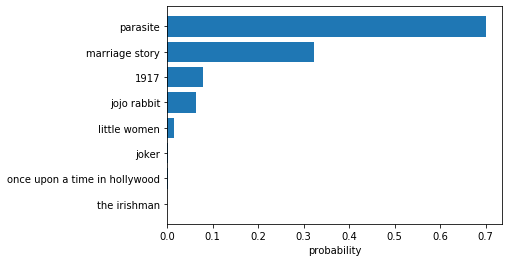

In [14]:
mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10,10), max_iter=1000, random_state=41)
mlp.fit(X, y)
y_pred = mlp.predict(X_2019)
y_prob = mlp.predict_proba(X_2019)
# print(y_prob)
# print(classifier.score)
DFX_2019.loc[:,'predicted_probability_mlp'] = y_prob[:,1]
clear_output()
print(mlp.score(X, y))
x = DFX_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)
x = x.iloc[::-1,:]


### Performance evaluation
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
print(mlp.score(X, y))
plt.barh(x['title'], x['predicted_probability_mlp'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# DeepNet Prediction

Train on 292 samples
Epoch 1/10
292/292 [==============================] - 0s 1ms/sample - loss: 0.5896 - accuracy: 0.7877
Epoch 2/10
292/292 [==============================] - 0s 60us/sample - loss: 0.5421 - accuracy: 0.7534
Epoch 3/10
292/292 [==============================] - 0s 64us/sample - loss: 0.5008 - accuracy: 0.8116
Epoch 4/10
292/292 [==============================] - 0s 68us/sample - loss: 0.4544 - accuracy: 0.8151
Epoch 5/10
292/292 [==============================] - 0s 56us/sample - loss: 0.4750 - accuracy: 0.8116
Epoch 6/10
292/292 [==============================] - 0s 72us/sample - loss: 0.4418 - accuracy: 0.8322
Epoch 7/10
292/292 [==============================] - 0s 54us/sample - loss: 0.4119 - accuracy: 0.8322
Epoch 8/10
292/292 [==============================] - 0s 63us/sample - loss: 0.3991 - accuracy: 0.8425
Epoch 9/10
292/292 [==============================] - 0s 75us/sample - loss: 0.3853 - accuracy: 0.8527
Epoch 10/10
292/292 [==============================] 

Text(0.5, 1.0, 'picture')

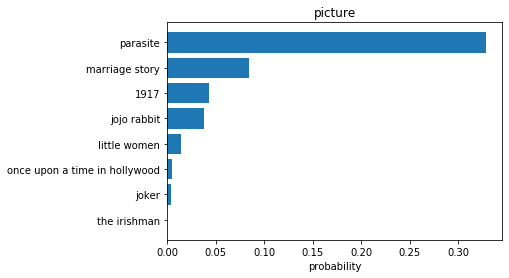

In [15]:
import tensorflow as tf
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu, input_dim=X.shape[1]))
model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
# model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(X, y, epochs = 10)
y_pred = model.predict([X_2019])

y_prob = y_pred
DFX_2019.loc[:,'predicted_probability_deep'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_deep', ascending=False).head(10)
x = x.iloc[::-1,:]

## Performance evaluation
plt.barh(x['title'], x['predicted_probability_deep'])
plt.xlabel('probability')
plt.title(category)
